In [ ]:
from NomPlot import nomogram
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import Output
from IPython.display import display, clear_output
from scipy.signal import butter, filtfilt
import scipy.signal as scs
import os
experiment_path = "/Users/luca/Desktop/Codici/Oscillation_perm/b1315v05rocF110_20"
data= pd.read_csv(experiment_path,delimiter='\t',skiprows=[1])


### Select the data

In [ ]:
ppa_label = widgets.HTML(value="<b>Up-stream pore pressure (Ppa):</b>")
ppa_press_selector = widgets.Dropdown(options=list(data.columns))
ppb_label = widgets.HTML(value="<b>Down-stream pore pressure (Ppb):</b>")
ppb_press_selector = widgets.Dropdown(options=list(data.columns))
time_label = widgets.HTML(value="<b>Time:</b>")
time_selector = widgets.Dropdown(options=list(data.columns))
thickness_label = widgets.HTML(value="<b>Fault thickness:</b>")
thickness_selector = widgets.Dropdown(options=list(data.columns))
disp_label = widgets.HTML(value="<b>Shear displacement:</b>")
displacement_selector = widgets.Dropdown(options=list(data.columns))
confirm_button = widgets.Button(
    description='Confirm',
    button_style='success',
)
output = widgets.Output()
def on_confirm_clicked(b):
    with output:
        clear_output()
        data['lp_disp_mm'] = data[displacement_selector.value]
        data['lt_ec_mm'] = data[thickness_selector.value]
        data['Ppa_press_MPa'] = data[ppa_press_selector.value]
        data['Ppb_press_MPa'] = data[ppb_press_selector.value]
        data['time_s'] = data[time_selector.value]

        print("✅ Selection confirmed:")
        print(f"- Displacement: {displacement_selector.value}")
        print(f"- Fault thickness: {thickness_selector.value}")
        print(f"- Up-stream pore pressure (Ppa): {ppa_press_selector.value}")
        print(f"- Down-stream pore pressure(Ppb): {ppb_press_selector.value}")
        print(f"- Time: {time_selector.value}")
confirm_button.on_click(on_confirm_clicked)
display(
    disp_label, displacement_selector,
    thickness_label, thickness_selector,
    ppa_label, ppa_press_selector,
    ppb_label, ppb_press_selector,
    time_label, time_selector,
    confirm_button, output
)

HTML(value='<b>Shear displacement:</b>')

Dropdown(options=('V-LVDT', 'H-Pot', 'H-LVDT', 'V-LOAD', 'H-LOAD', 'Pc-Press', 'Pc-Displ', 'Ppa-Press', 'Ppa-D…

HTML(value='<b>Fault thickness:</b>')

Dropdown(options=('V-LVDT', 'H-Pot', 'H-LVDT', 'V-LOAD', 'H-LOAD', 'Pc-Press', 'Pc-Displ', 'Ppa-Press', 'Ppa-D…

HTML(value='<b>Up-stream pore pressure (Ppa):</b>')

Dropdown(options=('V-LVDT', 'H-Pot', 'H-LVDT', 'V-LOAD', 'H-LOAD', 'Pc-Press', 'Pc-Displ', 'Ppa-Press', 'Ppa-D…

HTML(value='<b>Down-stream pore pressure (Ppb):</b>')

Dropdown(options=('V-LVDT', 'H-Pot', 'H-LVDT', 'V-LOAD', 'H-LOAD', 'Pc-Press', 'Pc-Displ', 'Ppa-Press', 'Ppa-D…

HTML(value='<b>Time:</b>')

Dropdown(options=('V-LVDT', 'H-Pot', 'H-LVDT', 'V-LOAD', 'H-LOAD', 'Pc-Press', 'Pc-Displ', 'Ppa-Press', 'Ppa-D…

Button(button_style='success', description='Confirm', style=ButtonStyle())

Output()

##### If reduced data, skip this part, if not pick the horizontal touch record number and, with the initial layer thickness, calculate real-time thickness

In [ ]:
initial_thick= 5
data['lt_ec_mm']= ((data['H-LVDT']-data['H-LVDT'].iloc[12283])+(initial_thick*2))/2
data['lp_disp_mm']= -(data['V-LVDT']-data['V-LVDT'].iloc[19234]) #### valori validi per l'esperimento b1315 non ridotto

#### Data slicing (we keep only the oscillation part of the data) and select the period

In [ ]:
%matplotlib qt
sliced_data = {}
selected_pointsx = []
selected_pointsy = []
period_pointsx = []
period_pointsy = []
period = None 
def on_double_click_initial(event):
    if event.dblclick and event.xdata is not None:
        selected_pointsx.append(event.xdata)
        selected_pointsy.append(event.ydata)
        print(f"⏱ Punto selezionato: {event.xdata:.2f} s")
        ax.scatter(event.xdata, event.ydata, color='blue', marker='x', s=100, label='Selected Point' if len(selected_pointsx) == 1 else "")
        fig.canvas.draw()

        if len(selected_pointsx) == 2:
            plt.close()
            plot_sliced_data()

def on_double_click_period(event):
    global period
    if event.dblclick and event.xdata is not None:
        period_pointsx.append(event.xdata)
        period_pointsy.append(event.ydata)
        ax2.scatter(event.xdata, event.ydata, color='green', marker='x', s=100, label='Period Point' if len(period_pointsx) == 1 else "",zorder=1000)
        fig2.canvas.draw()

        if len(period_pointsx) == 2:
            x1, x2 = sorted(period_pointsx)
            delta = x2 - x1
            step_options = np.array([50,75,100,125,150,175,200])
            period = int(step_options[np.argmin(np.abs(step_options - delta))])
            plt.close()
            print(f"\n✅ Selected period: {delta:.2f} s → Approximated to: {period} s")


def plot_sliced_data():
    global sliced_data, fig2, ax2

    start, end = sorted(selected_pointsx)
    mask = (data["time_s"] >= start) & (data["time_s"] <= end)
    sliced_data = {key: values[mask] for key, values in data.items()}

    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.plot(sliced_data["time_s"], sliced_data["Ppa_press_MPa"], label='Ppa_press_MPa', c='dodgerblue')
    ax2.plot(sliced_data["time_s"], sliced_data["Ppb_press_MPa"], label='Ppb_press_MPa', c='k')
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Fluid Pressure (MPa)")
    ax2.set_title("Select two points to calculate period (double click)")
    ax2.legend()
    fig2.canvas.mpl_connect('button_press_event', on_double_click_period)
    plt.show()

# Finestra iniziale
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data["time_s"], data["Ppa_press_MPa"], label='Ppa_press_MPa', c='dodgerblue')
ax.plot(data["time_s"], data["Ppb_press_MPa"], label='Ppb_press_MPa', c='k')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Fluid Pressure (MPa)")
ax.set_title("Select two points to have a oscillation window (double click)")
ax.legend()
fig.canvas.mpl_connect('button_press_event', on_double_click_initial)
plt.show()



⏱ Punto selezionato: 28463.07 s, 13.44 MPa
⏱ Punto selezionato: 29486.49 s, 13.44 MPa

✅ Selected period: 100.22 s → Approximated to: 100 s


#### Data filtering and detrend

In [ ]:
%matplotlib inline
time = sliced_data["time_s"]
ppa = sliced_data["Ppa_press_MPa"]
ppb = sliced_data["Ppb_press_MPa"]
ppb_det = ppb 
output = widgets.Output()

linear_x1 = widgets.FloatText(description='X1', value=selected_pointsx[0])
linear_y1 = widgets.FloatText(description='Y1', value=selected_pointsy[0])
linear_x2 = widgets.FloatText(description='X2', value=selected_pointsx[1])
linear_y2 = widgets.FloatText(description='Y2', value=selected_pointsy[1])
degree_poly = widgets.IntSlider(value=3, min=1, max=5, step=1, description='Grado')
freq_cutoff = widgets.FloatText(value=0.004, description='Frequenza')
detrend_options = ['Raw', 'Detrend Lineare', 'Detrend Polinomiale', 'Filtro Passa-Alto']
detrend_dropdown = widgets.Dropdown(
    options=detrend_options,
    value='Raw'
)

def update_ppb_det(_):
    global ppb_det  # Usa la variabile globale ppb_det per aggiornarla
    if detrend_dropdown.value == 'Detrend Lineare':
        if len(selected_pointsx) == 2 and len(selected_pointsy) == 2:
            ppb_fit = np.interp(time, selected_pointsx, selected_pointsy)
            ppb_det = ppb - ppb_fit
            ppb_det += ppb.iloc[0]
    elif detrend_dropdown.value == 'Detrend Polinomiale':
        coeffs = np.polyfit(time, ppb, degree_poly.value)
        poly_fit = np.polyval(coeffs, time)
        ppb_det = ppb - poly_fit + ppb.iloc[0]
    elif detrend_dropdown.value == 'Filtro Passa-Alto':
        fs = 1 / np.mean(np.diff(time))  
        nyq = fs / 2
        b, a = butter(1, freq_cutoff.value / nyq, btype='high')
        ppb_det = filtfilt(b, a, ppb)
        ppb_det += ppb.iloc[0] - ppb_det[0]
    else:
        ppb_det = ppb  # Se 'Raw' è selezionato, usa i dati raw come default

def generate_plot(_):
    with output:
        clear_output(wait=True)
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        axs[0, 0].plot(time, ppa, 'k', label='Ppa pressure')
        axs[0, 0].plot(time, ppb, 'b', label='Raw Ppb')
        axs[0, 0].set_title("Dati Raw")
        axs[0, 0].legend(loc='upper right')
        if len(selected_pointsx) == 2 and len(selected_pointsy) == 2:
            ppb_fit = np.interp(time, selected_pointsx, selected_pointsy)
            detrended_ppb = ppb - ppb_fit
            detrended_ppb += ppb.iloc[0]
            axs[0, 1].plot(time, ppa, 'k', label='Ppa pressure')
            axs[0, 1].plot(time, detrended_ppb, 'r', label='Detrended Ppb Lineare')
            axs[0, 1].set_title("Detrend Lineare")
            axs[0, 1].legend(loc='upper right')
        coeffs = np.polyfit(time, ppb, degree_poly.value)
        poly_fit = np.polyval(coeffs, time)
        detrended_ppb_poly = ppb - poly_fit + ppb.iloc[0]
        axs[1, 0].plot(time, ppa, 'k', label='Ppa pressure')
        axs[1, 0].plot(time, detrended_ppb_poly, 'gold', label='Detrended Ppb Polinomiale')
        axs[1, 0].set_title("Detrend Polinomiale")
        axs[1, 0].legend(loc='upper right')
        fs = 1 / np.mean(np.diff(time))  # Frequenza di campionamento
        nyq = fs / 2
        b, a = butter(1, freq_cutoff.value / nyq, btype='high')
        filtered_ppb = filtfilt(b, a, ppb)
        filtered_ppb += ppb.iloc[0] - filtered_ppb[0]
        axs[1, 1].plot(time, ppa, 'k', label='Ppa pressure')
        axs[1, 1].plot(time, filtered_ppb, 'g', label='Filtered Ppb')
        axs[1, 1].set_title("Filtro Passa-Alto")
        axs[1, 1].legend(loc='upper right')
        plt.tight_layout()
        plt.show()
        
plot_button = widgets.Button(
    description='Genera Grafico',
    style={'button_color': 'lightgreen'},  # Cambia il colore di sfondo
    layout=widgets.Layout(width='200px', height='50px', font_size='16px')  # Aumenta la larghezza, l'altezza e la dimensione del testo
)
plot_button.on_click(generate_plot)

detrend_dropdown.observe(update_ppb_det, names='value')
linear_x1.observe(update_ppb_det, names='value')
linear_y1.observe(update_ppb_det, names='value')
linear_x2.observe(update_ppb_det, names='value')
linear_y2.observe(update_ppb_det, names='value')
degree_poly.observe(update_ppb_det, names='value')
freq_cutoff.observe(update_ppb_det, names='value')

ui = widgets.VBox([
    widgets.Label("Detrend Lineare"),
    widgets.HBox([linear_x1, linear_y1]),
    widgets.HBox([linear_x2, linear_y2]),
    widgets.HBox([
        widgets.VBox([widgets.Label("Detrend Polinomiale", layout=widgets.Layout(margin='20px 0px 0px 0px')), widgets.HBox([degree_poly])]),
        widgets.VBox([widgets.Label("Filtro Passa-Alto", layout=widgets.Layout(margin='20px 0px 0px 0px')), widgets.HBox([freq_cutoff])])
    ]),
    widgets.HBox([plot_button], layout=widgets.Layout(margin='20px 0px 0px 200px')),
    widgets.Label("Selezionare il tipo di detrend per analisi dati",layout=widgets.Layout(margin='40px 0px 0px 20px')),
    widgets.HBox([detrend_dropdown], layout=widgets.Layout(margin='0px 0px 0px 20px'))
])
display(ui, output)


Output()

Text(0.5, 1.0, 'Dati pronti per analisi spettrale e filtro')

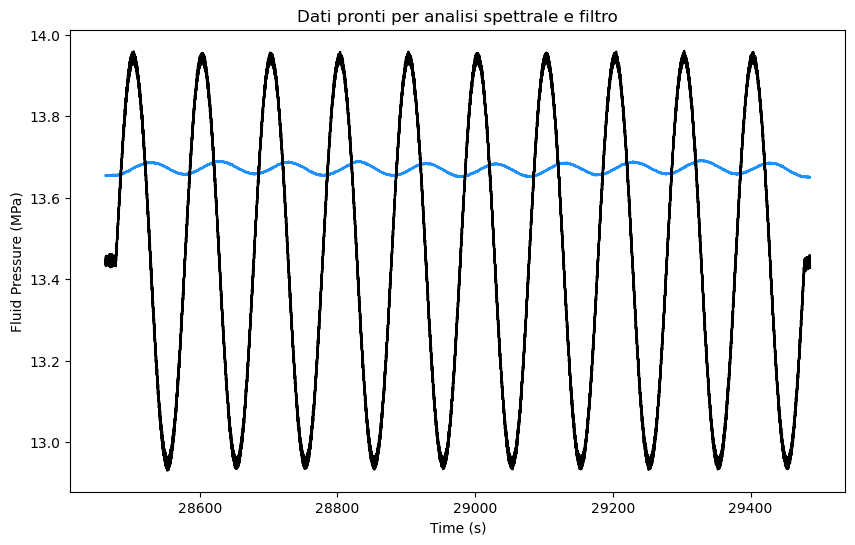

In [7]:
fig=plt.figure(figsize=(10,6))
plt.plot(time, ppb_det, label='Ppb_det', c='dodgerblue')
plt.plot(time, ppa, label='Ppa', c='k') 
plt.xlabel("Time (s)")
plt.ylabel("Fluid Pressure (MPa)")
plt.title("Dati pronti per analisi spettrale e filtro")

In [ ]:
T200_Ppa = ppa
T200_Ppb = ppb_det
T200_time = time
T200_LT= sliced_data['lt_ec_mm']
T200_str= sliced_data['lp_disp_mm']/sliced_data['lt_ec_mm']
Ppa_zeroed = ppa - np.mean(ppa)
Ppb_zeroed = ppb_det - np.mean(ppb_det)
Ppa_filt = None
Ppb_filt = None
def apply_filter(cutoff_freq, sampling_freq, order):
    global Ppa_filt, Ppb_filt 
    b, a = scs.butter(order, cutoff_freq / (sampling_freq / 2), btype='low', analog=False)
    Ppa_filt = scs.filtfilt(b, a, Ppa_zeroed)
    Ppb_filt = scs.filtfilt(b, a, Ppb_zeroed)
    return Ppa_zeroed, Ppb_zeroed, Ppa_filt, Ppb_filt
def update(_):
    # Ottieni i valori dai widget
    cutoff_freq = slider_cutoff.value
    sampling_freq = slider_sampling.value
    order = slider_order.value

    # Applica il filtro
    Ppa_zeroed, Ppb_zeroed, Ppa_filt, Ppb_filt = apply_filter(cutoff_freq, sampling_freq, order)

    # Aggiorna il grafico
    with output:
        clear_output(wait=True)  # Pulisce il grafico precedente
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(time, Ppa_zeroed, c='k', label='Ppa')
        ax.plot(time, Ppb_zeroed, c='r', label='Ppb')
        ax.plot(time, Ppa_filt, c='g', linestyle='--', label='Ppa_filt')
        ax.plot(time, Ppb_filt, c='b', linestyle='--', label='Ppb_filt')
        ax.legend(loc='upper right')
        plt.show()
slider_cutoff = widgets.FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='')
slider_sampling = widgets.FloatSlider(value=10, min=1, max=100, step=1, description='')
slider_order = widgets.IntSlider(value=3, min=1, max=5, step=1, description='')
slider_cutoff.layout = widgets.Layout(width='25%', margin='0 0 0 0px') 
slider_sampling.layout = widgets.Layout(width='25%', margin='0 0 0 0px') 
slider_order.layout = widgets.Layout(width='25%', margin='0 0 0 0px') 
label_cutoff = widgets.Label(value='Cutoff Frequency:')
label_sampling = widgets.Label(value='Sampling Frequency:')
label_order = widgets.Label(value='Filter Order:')
update_button = widgets.Button(description='Filtra il segnale', style={'button_color': 'lightgreen'})
update_button.on_click(update)
output = Output()
display(label_cutoff, slider_cutoff, label_sampling, slider_sampling, label_order, slider_order, update_button, output)

Label(value='Cutoff Frequency:')

FloatSlider(value=0.1, layout=Layout(margin='0 0 0 0px', width='25%'), max=1.0, min=0.01, step=0.01)

Label(value='Sampling Frequency:')

FloatSlider(value=10.0, layout=Layout(margin='0 0 0 0px', width='25%'), min=1.0, step=1.0)

Label(value='Filter Order:')

IntSlider(value=3, layout=Layout(margin='0 0 0 0px', width='25%'), max=5, min=1)

Button(description='Filtra il segnale', style=ButtonStyle(button_color='lightgreen'))

Output()

In [31]:
phase_a = None
phase_b = None
amp_a= None
amp_b= None
rec_rate=10
tot_len = len(Ppa_zeroed)
window = rec_rate * period
step = 25  # the point the window advancs
num_windows = int((tot_len - window) / step) + 1
lt_steps = np.zeros(num_windows)
time_steps = np.zeros(num_windows)
strain_steps = np.zeros(num_windows)


def fourier_analysis(rec_rate, period, Ppa_zeroed, Ppb_filt):
    global phase_a, phase_b, amp_a, amp_b
    
    # Set up parameters
    tot_len = len(Ppa_zeroed)
    window = int(rec_rate * period)
    step = 25
    num_windows = int((tot_len - window) / step) + 1

    # Initialize arrays
    amp_a = np.zeros(num_windows)
    phase_a = np.zeros(num_windows)
    amp_b = np.zeros(num_windows)
    phase_b = np.zeros(num_windows)

    # Set up plots
    fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    plt.subplots_adjust(hspace=0.001)
    
    # Labels
    ax[0].set_ylabel('Amplitude Ppa')
    ax[1].set_ylabel('Phase Ppa')
    ax[2].set_ylabel('Amplitude Ppb')
    ax[3].set_ylabel('Phase Ppb')
    ax[3].set_xlabel('Frequency')
    ax[0].set_xlim(-0.05, 0.05) 
    ax[1].set_xlim(-0.05, 0.05) 
    ax[2].set_xlim(-0.05, 0.05) 
    ax[3].set_xlim(-0.05, 0.05) 

    # Plot Ppa
    kk = 0
    for i in np.arange(0, tot_len - window, step):
        PPA = Ppa_zeroed[i:i + window]
        amp = np.fft.fft(PPA)
        amp1 = np.abs(amp)
        n = amp1.size
        timestep = 1 / rec_rate
        freq = np.fft.fftfreq(n, d=timestep)

        ax[0].plot(freq, amp1 / n, alpha=0.5)

        freq_pos = np.argwhere(freq > 0).flatten()
        max_ampPpa = np.max(amp1[freq_pos] / n)
        max_freq_pos = np.argmax(amp1[freq_pos] / n)
        max_freqPpa = freq[freq_pos][max_freq_pos]

        amp_1 = np.copy(amp)
        threshold = np.max(np.abs(amp_1)) / 10  # Soglia per escludere componenti deboli
        amp_1[np.abs(amp) < threshold] = 0  # Annulla componenti deboli
        phase_1 = np.arctan2(np.imag(amp_1), np.real(amp_1)) * 180 / np.pi

        ax[1].plot(freq, phase_1, alpha=0.5)

        max_phasePpa = phase_1[freq_pos][max_freq_pos]
        amp_a[kk] = max_ampPpa * 2
        phase_a[kk] = max_phasePpa
        kk += 1

    # Plot Ppb
    kk = 0
    for i in np.arange(0, tot_len - window, step):
        PPB = Ppb_filt[i:i + window]
        amp = np.fft.fft(PPB)
        amp1 = np.abs(amp)
        n = amp1.size
        freq = np.fft.fftfreq(n, d=timestep)

        ax[2].plot(freq, amp1 / n, alpha=0.5)

        amp_2 = np.copy(amp)
        threshold = np.max(np.abs(amp_2)) / 10  # Soglia per escludere componenti deboli
        amp_2[np.abs(amp) < threshold] = 0  # Annulla componenti deboli
        phase_2 = np.arctan2(np.imag(amp_2), np.real(amp_2)) * 180 / np.pi

        freq_pos = np.argwhere(freq > 0).flatten()
        max_ampPpb = np.max(amp1[freq_pos] / n)
        max_freq_pos = np.argmax(amp1[freq_pos] / n)
        max_freqPpb = freq[freq_pos][max_freq_pos]

        ax[3].plot(freq, phase_2, alpha=0.5)

        max_phasePpb = phase_2[freq_pos][max_freq_pos]
        amp_b[kk] = max_ampPpb * 2
        phase_b[kk] = max_phasePpb
        # Average layer thickness for the window
        lt_steps[kk] = np.mean(T200_LT[i:i + window])

        # Average time for the window
        time_steps[kk] = np.mean(T200_time[i:i + window])

        # Average strain for the window
        strain_steps[kk] = np.mean(T200_str[i:i + window])
        kk += 1

    plt.show()

    print(f"Dominant Frequency Ppa: {np.round(max_freqPpa,2)} Hz, Period: {np.round(1./max_freqPpa,3)} s, Phase: {np.round(max_phasePpa,3)}°")
    print(f"Dominant Frequency Ppb: {np.round(max_freqPpb,2)} Hz, Period: {np.round(1./max_freqPpb,3)} s, Phase: {np.round(max_phasePpb,3)}°")

    # Return the phase arrays to be used later
    return phase_a, phase_b, amp_a, amp_b


# Creazione dei widget
rec_rate_slider = widgets.FloatSlider(value=10, min=1, max=100, step=1, description='Rec Rate (Hz)')
period_slider = widgets.FloatSlider(value=period, min=10, max=500, step=10, description='Period (s)')

# Uso di widgets.interactive per aggiornare dinamicamente il grafico
interactive_plot = widgets.interactive(fourier_analysis, 
                                       rec_rate=rec_rate_slider, 
                                       period=period_slider, 
                                       Ppa_zeroed=widgets.fixed(Ppa_zeroed), 
                                       Ppb_filt=widgets.fixed(Ppb_filt))

display(rec_rate_slider, period_slider, interactive_plot)


FloatSlider(value=10.0, description='Rec Rate (Hz)', min=1.0, step=1.0)

FloatSlider(value=100.0, description='Period (s)', max=500.0, min=10.0, step=10.0)

interactive(children=(FloatSlider(value=10.0, description='Rec Rate (Hz)', min=1.0, step=1.0), FloatSlider(val…

In [33]:
fig=plt.figure(figsize=(10.6,6))
plt.subplots_adjust(hspace=0.001)
ax1 = plt.subplot(211)
ax1.plot(time_steps,phase_a,'k',label='Up-stream')
ax1.plot(time_steps,phase_b,'dodgerblue',label='Down-Stream')
ax1.set_ylabel('Phase, degree')
ax1.legend(loc='best')
ax2 = plt.subplot(212)
ax2.plot(time_steps,amp_a,'k')
ax2.set_ylabel('Up-stream Amplitude, MPa')
ax2.set_xlabel('Time, s')
ax3=ax2.twinx()
ax3.plot(time_steps,amp_b,'dodgerblue')
ax3.set_ylabel('Down-stream Amplitude, MPa', color='dodgerblue')

# Calculate phase difference and amplitude ratio
phase_diff = phase_b - phase_a
phase_diff = np.abs(np.mod(phase_diff+180,360)-180)
phase_diff= np.deg2rad(phase_diff)
amp_ratio = amp_b / amp_a

# Plot amplitude ratio and phase difference over time
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(time_steps, amp_ratio, 'k', label='Amplitude Ratio')
ax1.set_ylabel('Amplitude Ratio, MPa', color='k')
ax1.set_xlabel('Time, s')
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='k')

ax2 = ax1.twinx()
ax2.plot(time_steps, phase_diff, 'dodgerblue', label='Phase Difference')
ax2.set_ylabel('Phase Difference (cycles)', color='dodgerblue')
ax2.tick_params(axis='y', labelcolor='dodgerblue')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')
plt.title('Amplitude Ratio and Phase Difference Over Time')
fig.tight_layout()
plt.show()

/Users/luca/Desktop/Codici/Oscillation_perm/NomPlot.py:189: RuntimeWarning: overflow encountered in sinh
  term = (1 + 1j) / np.sqrt(eta[n] * xi[m]) * np.sinh((1 + 1j) * np.sqrt(xi[m] / eta[n])) + np.cosh((1 + 1j) * np.sqrt(xi[m] / eta[n]))
/Users/luca/Desktop/Codici/Oscillation_perm/NomPlot.py:189: RuntimeWarning: invalid value encountered in scalar multiply
  term = (1 + 1j) / np.sqrt(eta[n] * xi[m]) * np.sinh((1 + 1j) * np.sqrt(xi[m] / eta[n])) + np.cosh((1 + 1j) * np.sqrt(xi[m] / eta[n]))
/Users/luca/Desktop/Codici/Oscillation_perm/NomPlot.py:189: RuntimeWarning: overflow encountered in cosh
  term = (1 + 1j) / np.sqrt(eta[n] * xi[m]) * np.sinh((1 + 1j) * np.sqrt(xi[m] / eta[n])) + np.cosh((1 + 1j) * np.sqrt(xi[m] / eta[n]))
/Users/luca/Desktop/Codici/Oscillation_perm/NomPlot.py:190: RuntimeWarning: invalid value encountered in scalar power
  A1[n, m] = np.abs(term**-1)
/Users/luca/Desktop/Codici/Oscillation_perm/NomPlot.py:191: RuntimeWarning: invalid value encountered in scalar p

<Figure size 1000x800 with 0 Axes>

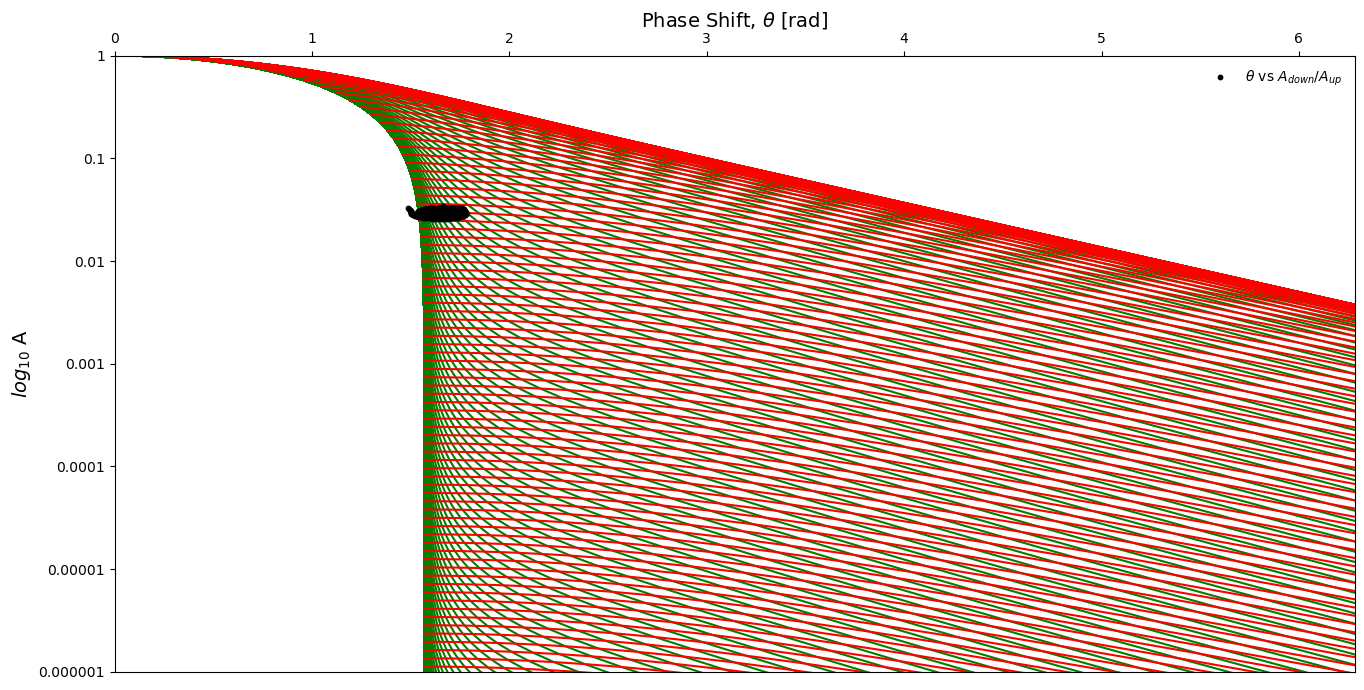

In [24]:
fig=plt.figure(figsize=(10,8))
nomogram(2,-10,150,-20,20,400)
plt.scatter(phase_diff[:], np.log10(amp_ratio[:]), c='k',s=10, label=(r'$\theta$ vs $A_{down}/A_{up}$'),zorder=1000)
plt.legend(frameon=False)



# Inversion

In [34]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.interpolate import griddata
lookup= np.load('lookup.npz')
xlim = (0.15*6.28, 0.35*6.28)
eta_range = [1e-5, 100]   # Range plausibile per η
xi_range = [1e-6, 20] 

def get_initial_guess(A, phi, lookup):
    eta0 = griddata((np.log10(lookup['A']), lookup['phi']), np.log10(lookup['eta']), (np.log10(A), phi), method='linear')
    xi0 = griddata((np.log10(lookup['A']), lookup['phi']), lookup['xi'], (np.log10(A), phi), method='linear')
    return eta0, xi0

def bern_eq_mismatch(x, A, phi, lookup, w=0.5, reg=1e-3):
    A_i = 1 / np.abs((1 + 1j) * np.sinh((1 + 1j) * np.sqrt(x[1] / x[0])) / np.sqrt(x[1] * x[0]) + np.cosh((1 + 1j) * np.sqrt(x[1] / x[0])))
    theta_i = np.angle((1 + 1j) * np.sinh((1 + 1j) * np.sqrt(x[1] / x[0])) / np.sqrt(x[1] * x[0]) + np.cosh((1 + 1j) * np.sqrt(x[1] / x[0])))

    mismatch = np.sum(w * (np.log10(A_i) / np.log10(A) - 1)**2 + (1 - w) * (theta_i - phi)**2)
    regularization = reg * (x[0]**2 + x[1]**2)
    return mismatch + regularization

# Add finer_grid_search definition here
def finer_grid_search(A, phi, lookup, eta_range, xi_range, w=0.5, grid_size=50):
    eta_vals = np.logspace(np.log10(eta_range[0]), np.log10(eta_range[1]), num=grid_size)
    xi_vals = np.logspace(np.log10(xi_range[0]), np.log10(xi_range[1]), num=grid_size)
    min_mismatch = float('inf')
    best_eta, best_xi = None, None

    for eta in eta_vals:
        for xi in xi_vals:
            mismatch = bern_eq_mismatch([eta, xi], A, phi, lookup, w)
            if mismatch < min_mismatch:
                min_mismatch = mismatch
                best_eta, best_xi = eta, xi

    # If no match found, return a sensible default, such as the middle of the range
    if best_eta is None or best_xi is None:
        best_eta = np.median(eta_vals)
        best_xi = np.median(xi_vals)
        print('no_match')

    return best_eta, best_xi

# Coarse-to-Fine and Multi-Start Functions
def coarse_to_fine_search(A, phi, lookup, eta_range, xi_range, w=0.5, grid_size=50):
    # Coarse grid search
    coarse_grid_size = 30
    eta_coarse, xi_coarse = finer_grid_search(A, phi, lookup, eta_range, xi_range, w, coarse_grid_size)

    # Fine grid search around coarse result
    fine_grid_size = grid_size
    eta_fine_range = [eta_coarse / 2, eta_coarse * 2]
    xi_fine_range = [xi_coarse / 2, xi_coarse * 2]

    eta_fine, xi_fine = finer_grid_search(A, phi, lookup, eta_fine_range, xi_fine_range, w, fine_grid_size)

    return eta_fine, xi_fine

def multi_start_optimization(A, phi, lookup, eta_range, xi_range, w=0.5, grid_size=50, reg=1e-3, num_starts=5):
    best_eta, best_xi = None, None
    min_mismatch = float('inf')

    for _ in range(num_starts):
        eta_start, xi_start = coarse_to_fine_search(A, phi, lookup, eta_range, xi_range, w)
        x0 = [eta_start, xi_start]
        
        bounds = [(1e-10, None), (1e-50, None)]
        options = {
            'disp': False,
            'maxiter': 400,
            'gtol': 1e-12,
            'eps': 1e-10
        }
        
        res = minimize(bern_eq_mismatch, x0, args=(A, phi, lookup, w, reg), method='L-BFGS-B', bounds=bounds, options=options)

        if res.fun < min_mismatch:
            min_mismatch = res.fun
            best_eta = res.x[0]
            best_xi = res.x[1]

    return best_eta, best_xi

def solve_eta_xi_mismatch(A, phi, lookup, eta_range, xi_range, w=0.5, grid_size=50, num_starts=5, reg=1e-3):
    best_eta, best_xi = multi_start_optimization(A, phi, lookup, eta_range, xi_range, w, grid_size, reg, num_starts)

    # If no match found, return the median of the search range
    if best_eta is None or best_xi is None:
        best_eta = np.median(np.logspace(np.log10(eta_range[0]), np.log10(eta_range[1]), num=grid_size))
        best_xi = np.median(np.logspace(np.log10(xi_range[0]), np.log10(xi_range[1]), num=grid_size))
        print('no_match - using default values')

    eta = max(best_eta, -10)
    xi = max(best_xi, 1e-6)

    return eta, xi

def estimate_uncertainties(A, phi, N, lookup, eta_range, xi_range, w=0.5, grid_size=50, reg=1e-3):
    eta, xi, _, _, _ = solve_eta_xi_mismatch(A, phi, lookup, eta_range, xi_range, w, grid_size, num_starts=5, reg=reg)

    e_A = 1e-3
    e_phi = 4e-3

    Adist = A + e_A * np.random.randn(20)
    phidist = phi + e_phi * np.random.randn(20)
    eta_dist = np.zeros_like(Adist)
    xi_dist = np.zeros_like(Adist)

    for i in range(len(Adist)):
        eta_temp, xi_temp, _, _, _ = solve_eta_xi_mismatch(Adist[i], phidist[i], lookup, eta_range, xi_range, w, grid_size, reg=reg)
        eta_dist[i] = eta_temp
        xi_dist[i] = xi_temp

    ind = np.where(xi_dist < 16)
    
    e_eta = norm.fit(eta_dist[ind])[1]
    e_xi = norm.fit(xi_dist[ind])[1]

    return eta, e_eta, xi, e_xi

def min_phi_at_amplitude(A, lookup, tol=0.1):
    """
    Restituisce il valore minimo di φ per i dati della lookup table aventi 
    log10(A) entro una tolleranza tol da log10(A) corrente.
    """
    logA = np.log10(A)
    lookup_logA = np.log10(lookup['A'])
    # Seleziona gli indici dove la differenza in log10 è inferiore a tol
    indices = np.where(np.abs(lookup_logA - logA) < tol)[0]
    if len(indices) == 0:
        # Se non trovi punti vicini, prendi quello più vicino
        idx = np.argmin(np.abs(lookup_logA - logA))
        return lookup['phi'][idx]
    else:
        return np.min(lookup['phi'][indices])

def is_point_inside_nomogram(A, phi, lookup, tol=0.1):
    """
    Determina se il punto (A, φ) cade "dentro" il nomogramma, ovvero se φ 
    è maggiore o uguale al minimo valore di fase associato ad A (entro una 
    tolleranza in log10(A)).
    """
    min_phi = min_phi_at_amplitude(A, lookup, tol)
    return phi >= min_phi

eta_values = [None] * len(amp_ratio)
xi_values  = [None] * len(amp_ratio)
mismatch_values = [None] * len(amp_ratio)

for i in range(len(amp_ratio)):
    A_i = amp_ratio[i]
    phi_i = phase_diff[i]

    if is_point_inside_nomogram(A_i, phi_i, lookup):
        # Punto dentro il nomogramma: usa il metodo di inversione
        eta_opt, xi_opt = solve_eta_xi_mismatch(A_i, phi_i, lookup, eta_range, xi_range)
        mismatch = bern_eq_mismatch([eta_opt, xi_opt], A_i, phi_i, lookup)
        print(f"Punto {i+1}: dentro il nomogramma -> inversione: η = {eta_opt:.3e}, ξ = {xi_opt:.3e}, mismatch = {mismatch:.3e}")
    else:
        # Punto fuori dal nomogramma: usa il metodo semplificato
        eta_opt = (2 * A_i) / np.sqrt(1 - A_i**2)
        xi_opt = 1e-6  # Valore predefinito
        mismatch = np.nan  # Non valutiamo il mismatch per questi
        print(f"Punto {i+1}: fuori dal nomogramma -> metodo semplificato: η = {eta_opt:.3e}, ξ = {xi_opt:.3e} (no mismatch)")

    eta_values[i] = eta_opt
    xi_values[i] = xi_opt
    mismatch_values[i] = mismatch

/var/folders/fg/6vd244v94r77p2pvf34_msv40000gn/T/ipykernel_16356/3137997637.py:128: RuntimeWarning: divide by zero encountered in log10
  lookup_logA = np.log10(lookup['A'])
/var/folders/fg/6vd244v94r77p2pvf34_msv40000gn/T/ipykernel_16356/3137997637.py:16: RuntimeWarning: overflow encountered in sinh
  A_i = 1 / np.abs((1 + 1j) * np.sinh((1 + 1j) * np.sqrt(x[1] / x[0])) / np.sqrt(x[1] * x[0]) + np.cosh((1 + 1j) * np.sqrt(x[1] / x[0])))
/var/folders/fg/6vd244v94r77p2pvf34_msv40000gn/T/ipykernel_16356/3137997637.py:16: RuntimeWarning: invalid value encountered in scalar multiply
  A_i = 1 / np.abs((1 + 1j) * np.sinh((1 + 1j) * np.sqrt(x[1] / x[0])) / np.sqrt(x[1] * x[0]) + np.cosh((1 + 1j) * np.sqrt(x[1] / x[0])))
/var/folders/fg/6vd244v94r77p2pvf34_msv40000gn/T/ipykernel_16356/3137997637.py:16: RuntimeWarning: invalid value encountered in scalar divide
  A_i = 1 / np.abs((1 + 1j) * np.sinh((1 + 1j) * np.sqrt(x[1] / x[0])) / np.sqrt(x[1] * x[0]) + np.cosh((1 + 1j) * np.sqrt(x[1] / x[0]))

Punto 1: dentro il nomogramma -> inversione: η = 6.955e-02, ξ = 2.656e-02, mismatch = 5.543e-06
Punto 2: dentro il nomogramma -> inversione: η = 6.622e-02, ξ = 2.361e-02, mismatch = 4.943e-06
Punto 3: dentro il nomogramma -> inversione: η = 6.361e-02, ξ = 2.019e-02, mismatch = 4.454e-06
Punto 4: dentro il nomogramma -> inversione: η = 6.171e-02, ξ = 1.682e-02, mismatch = 4.091e-06
Punto 5: dentro il nomogramma -> inversione: η = 6.042e-02, ξ = 1.394e-02, mismatch = 3.846e-06
Punto 6: dentro il nomogramma -> inversione: η = 5.960e-02, ξ = 1.196e-02, mismatch = 3.696e-06
Punto 7: dentro il nomogramma -> inversione: η = 5.905e-02, ξ = 1.106e-02, mismatch = 3.609e-06
Punto 8: dentro il nomogramma -> inversione: η = 5.858e-02, ξ = 1.074e-02, mismatch = 3.548e-06
Punto 9: dentro il nomogramma -> inversione: η = 5.817e-02, ξ = 1.036e-02, mismatch = 3.491e-06
Punto 10: dentro il nomogramma -> inversione: η = 5.783e-02, ξ = 9.906e-03, mismatch = 3.443e-06
Punto 11: dentro il nomogramma -> inver

In [35]:
plt.scatter(np.arange(0,len(mismatch_values),1),mismatch_values)

In [36]:
def bern_model(eta, xi):
    if eta < 1e-12 or xi < 1e-12:  # Protezione per valori piccoli
        return np.nan, np.nan
    
    z = (1 + 1j) * np.sqrt(xi / eta)
    term = 1 / (np.cosh(z) + (1 + 1j) / (np.sqrt(eta * xi) + 1e-12) * np.sinh(z))
    
    A_calc = np.abs(term)
    phi_calc = (np.angle(term))
    phi_calc= np.abs(phi_calc)
    
    return A_calc, phi_calc
amp = np.zeros_like(amp_ratio)
phase = np.zeros_like(phase_diff)
for i in range(len(eta_values)):
    amp[i], phase[i] = bern_model(eta_values[i], xi_values[i])
fig,ax=plt.subplots(2,1,figsize=(8,6))
ax[0].plot(amp_ratio,c='k',label='Original amplitude ratio')
ax[0].plot(amp,c='r',label='Inverted amplitude ratio')
ax[1].plot(phase_diff,c='k',label='Original phase shift')
ax[1].plot(phase,c='r',label='Inverted phase shift')
ax[0].set_ylabel('Amplitude ratio')
ax[1].set_ylabel('Phase shift')
ax[0].legend(frameon= False)
ax[1].legend(frameon=False)

In [30]:
%matplotlib qt
#fig=plt.figure(figsize=(10,8))
nomogram(2,-10,150,-20,20,400)
plt.scatter(phase_diff[150:], np.log10(amp_ratio[150:]), c='k',s=70, label=(r'$\theta$ vs $A_{down}/A_{up}$'),zorder=1000)
plt.scatter(phase, np.log10(amp), c='r',s=50,marker='x', label=(r'Inverted $\theta$ vs $A_{down}/A_{up}$'),zorder=10000)
plt.legend(frameon=False)

/Users/luca/Desktop/Codici/Oscillation_perm/NomPlot.py:189: RuntimeWarning: overflow encountered in sinh
  term = (1 + 1j) / np.sqrt(eta[n] * xi[m]) * np.sinh((1 + 1j) * np.sqrt(xi[m] / eta[n])) + np.cosh((1 + 1j) * np.sqrt(xi[m] / eta[n]))
/Users/luca/Desktop/Codici/Oscillation_perm/NomPlot.py:189: RuntimeWarning: invalid value encountered in scalar multiply
  term = (1 + 1j) / np.sqrt(eta[n] * xi[m]) * np.sinh((1 + 1j) * np.sqrt(xi[m] / eta[n])) + np.cosh((1 + 1j) * np.sqrt(xi[m] / eta[n]))
/Users/luca/Desktop/Codici/Oscillation_perm/NomPlot.py:189: RuntimeWarning: overflow encountered in cosh
  term = (1 + 1j) / np.sqrt(eta[n] * xi[m]) * np.sinh((1 + 1j) * np.sqrt(xi[m] / eta[n])) + np.cosh((1 + 1j) * np.sqrt(xi[m] / eta[n]))
/Users/luca/Desktop/Codici/Oscillation_perm/NomPlot.py:190: RuntimeWarning: invalid value encountered in scalar power
  A1[n, m] = np.abs(term**-1)
/Users/luca/Desktop/Codici/Oscillation_perm/NomPlot.py:191: RuntimeWarning: invalid value encountered in scalar p

In [37]:
experiment_filename = os.path.basename(experiment_path)
experiment_code = experiment_filename[:5]
output_filename = f"inversion_{experiment_code}.txt"
records= np.arange(0,len(time_steps),1)
# Salvataggio DataFrame
df = pd.DataFrame({
    'amp_ratio': amp_ratio,
    'phase_diff': phase_diff,
    'layer_thickness':lt_steps,
    'strain':strain_steps,
    "eta": eta_values,
    "xi": xi_values,
    'amp_inverted': amp,
    'phase_inverted': phase,
    'mismatch': mismatch_values,
    'records_na':records,
    'time':time_steps,
})

df.to_csv(f'{output_filename}', sep="\t", index=False)